In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch import optim
from tqdm import tqdm


import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 빈 딕셔너리 생성
rolled_one_dfs = {}

# Preprocessed_Data 디렉토리 내의 모든 CSV 파일을 읽어서 딕셔너리에 저장
directory_path = 'Preprocessed_Data'
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        key = filename.split('.')[0]  # 파일명에서 확장자를 제거하여 키로 사용
        csv_filepath = os.path.join(directory_path, filename)
        df = pd.read_csv(csv_filepath)
        rolled_one_dfs[key] = df
        print(f"Loaded {csv_filepath} into rolled_one_dfs[{key}]")

# 딕셔너리 확인 (선택 사항)
for key, df in rolled_one_dfs.items():
    print(f"{key}: {df.shape}")


Loaded Preprocessed_Data/lphost14_wls1.csv into rolled_one_dfs[lphost14_wls1]
Loaded Preprocessed_Data/lphost07_wls1.csv into rolled_one_dfs[lphost07_wls1]
Loaded Preprocessed_Data/lphost15_wls1.csv into rolled_one_dfs[lphost15_wls1]
Loaded Preprocessed_Data/lphost14_wls2.csv into rolled_one_dfs[lphost14_wls2]
Loaded Preprocessed_Data/lphost09_wls1.csv into rolled_one_dfs[lphost09_wls1]
Loaded Preprocessed_Data/lphost17_wls1.csv into rolled_one_dfs[lphost17_wls1]
Loaded Preprocessed_Data/lphost11_wls1.csv into rolled_one_dfs[lphost11_wls1]
Loaded Preprocessed_Data/lphost17_wls2.csv into rolled_one_dfs[lphost17_wls2]
Loaded Preprocessed_Data/lphost07_wls2.csv into rolled_one_dfs[lphost07_wls2]
Loaded Preprocessed_Data/lphost06_wls1.csv into rolled_one_dfs[lphost06_wls1]
Loaded Preprocessed_Data/lphost18_wls2.csv into rolled_one_dfs[lphost18_wls2]
Loaded Preprocessed_Data/lphost08_wls2.csv into rolled_one_dfs[lphost08_wls2]
Loaded Preprocessed_Data/lphost15_wls2.csv into rolled_one_dfs[l

In [3]:
rolled_one_labels = dict()
for key in rolled_one_dfs.keys():
    rolled_one_labels[key] = rolled_one_dfs[key].iloc[:, 0]
    rolled_one_labels[key].astype(int)

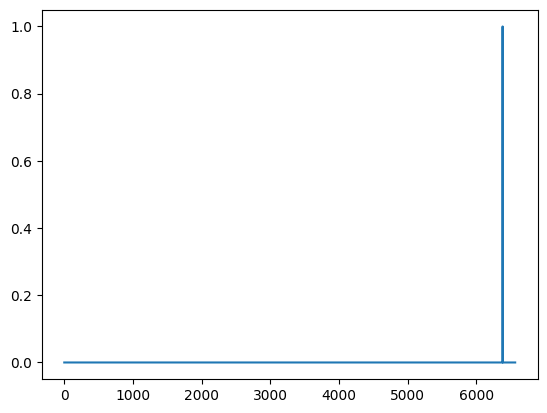

In [4]:
plt.plot(rolled_one_labels['lphost06_wls1'])

In [5]:
features_name = rolled_one_dfs['lphost06_wls1'].columns
rolled_one_dfs['lphost06_wls1'].columns = range(rolled_one_dfs['lphost06_wls1'].shape[1]) # column name을 index로 변경
print(rolled_one_dfs['lphost06_wls1'].shape)
rolled_one_dfs['lphost06_wls1'].head()

(6569, 134)


,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,0.0,0.507686,0.982992,0.5,0.0,0.0,0.666347,0.0,0.0,0.011111,...,0.0,0.120235,0.5,0.011111,0.385987,0.0,0.0,0.0,0.001175,0.0
1,0.0,0.507686,0.982992,0.5,0.0,0.0,0.666584,0.0,0.0,0.027778,...,0.0,0.120235,0.5,0.027778,0.386007,0.0,0.0,0.0,0.001175,0.0
2,0.0,0.507686,0.982992,0.5,0.0,0.0,0.663203,0.0,0.0,0.011111,...,0.0,0.120235,0.5,0.011111,0.385763,0.0,0.0,0.0,0.000714,0.0
3,0.0,0.507686,0.982992,0.5,0.0,0.0,0.663741,0.0,0.0,0.022222,...,0.0,0.120235,0.5,0.022222,0.385816,0.0,0.0,0.0,0.000924,0.0
4,0.0,0.507686,0.982992,0.5,0.0,0.0,0.667260,0.0,0.0,0.016667,...,0.0,0.120235,0.5,0.016667,0.386129,0.0,0.0,0.0,0.001553,0.0


In [6]:
rolled_one_labels['lphost06_wls1']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6564    0.0
6565    0.0
6566    0.0
6567    0.0
6568    0.0
Name: 0, Length: 6569, dtype: float64

LGBM으로 특징 선택하기

In [7]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, plot_importance

def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)

    # 특징의 중요도를 기반으로 정렬
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':ftr_train.columns})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)

    # 중요도가 높은 특징 선택 (예: 상위 10개 특징)
    selected_features = feature_imp.head(21)['Feature']

    return selected_features

In [8]:
# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(rolled_one_dfs['lphost06_wls1'].drop(columns=0), rolled_one_labels['lphost06_wls1'].astype(np.float32), test_size=0.2, random_state=42)

print('##LGBMClassifier 성능 예측')
lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=31, n_jobs=-1, boost_from_average=False)
top_features = get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

##LGBMClassifier 성능 예측
[LightGBM] [Info] Number of positive: 1, number of negative: 5254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13094
[LightGBM] [Info] Number of data points in the train set: 5255, number of used features: 93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [9]:
features = np.insert(top_features.values, 0, 0)

In [10]:
select_dfs = rolled_one_dfs['lphost06_wls1'][features]
select_dfs

,0,8,78,16,113,1,10,26,2,56,...,132,31,6,24,4,11,12,82,91,55
0,0.0,0.0,0.285714,0.000000,0.5,0.507686,0.047059,0.001083,0.982992,2.458957e-07,...,0.001175,0.000362,0.666347,0.000000,0.0,0.48416,0.511750,0.247678,0.000140,0.263738
1,0.0,0.0,0.285714,0.000000,0.5,0.507686,0.047059,0.001100,0.982992,2.704852e-06,...,0.001175,0.000362,0.666584,0.000000,0.0,0.48416,0.501843,0.247678,0.000138,0.378064
2,0.0,0.0,0.285714,0.000000,0.5,0.507686,0.047059,0.001150,0.982992,3.688435e-06,...,0.000714,0.000725,0.663203,0.000000,0.0,0.48416,0.489088,0.247678,0.000298,0.245254
3,0.0,0.0,0.285714,0.000000,0.5,0.507686,0.047059,0.001150,0.982992,2.458957e-07,...,0.000924,0.000725,0.663741,0.002640,0.0,0.48416,0.478726,0.247678,0.000291,0.343835
4,0.0,0.0,0.285714,0.000000,0.5,0.507686,0.047059,0.001133,0.982992,0.000000e+00,...,0.001553,0.000362,0.667260,0.004950,0.0,0.48416,0.468192,0.247678,0.000140,0.253753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,0.0,0.0,0.285714,0.514706,0.5,0.280360,0.376471,0.001133,0.880946,1.026915e-03,...,0.000252,0.000362,0.665050,0.049505,0.0,0.48416,0.660371,0.222380,0.000278,0.479398
6565,0.0,0.0,0.285714,0.514706,0.5,0.280360,0.376471,0.001250,0.880946,1.023739e-03,...,0.001092,0.000362,0.665403,0.049505,0.0,0.48416,0.662234,0.222380,0.000264,0.485605
6566,0.0,0.0,0.285714,0.514706,0.5,0.280360,0.376471,0.001967,0.880946,1.334168e-03,...,0.001092,0.000362,0.665235,0.049505,0.0,0.48416,0.646205,0.222380,0.000273,0.450114
6567,0.0,0.0,0.285714,0.514706,0.5,0.280360,0.376471,0.002783,0.880946,9.733714e-04,...,0.000336,0.000362,0.665246,0.049505,0.0,0.48416,0.634578,0.222380,0.000260,0.411601


In [11]:
sum(select_dfs[0]), [i for i, value in enumerate(select_dfs[0]) if abs(value-1) < 1e-5]

(0.9999999998999988, [6385])

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

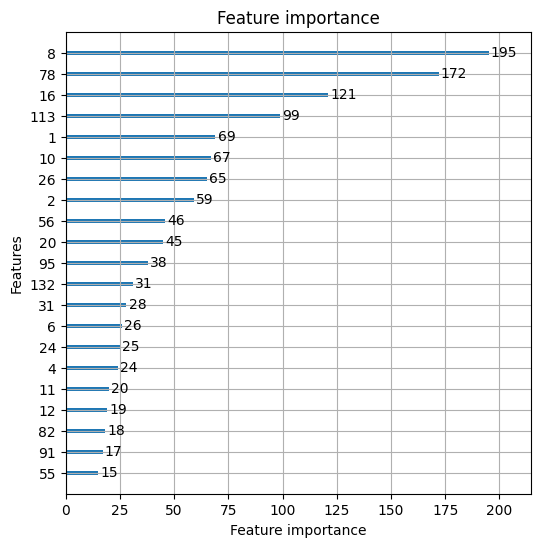

In [12]:
fig, ax = plt.subplots(figsize = (6, 6))
plot_importance(lgbm_clf, ax=ax, max_num_features=21)

In [13]:
for i, c in zip(top_features.values, features_name[top_features.values].values):
    print(i, c)

8 8
78 78
16 16
113 113
1 1
10 10
26 26
2 2
56 56
20 20
95 95
132 132
31 31
6 6
24 24
4 4
11 11
12 12
82 82
91 91
55 55


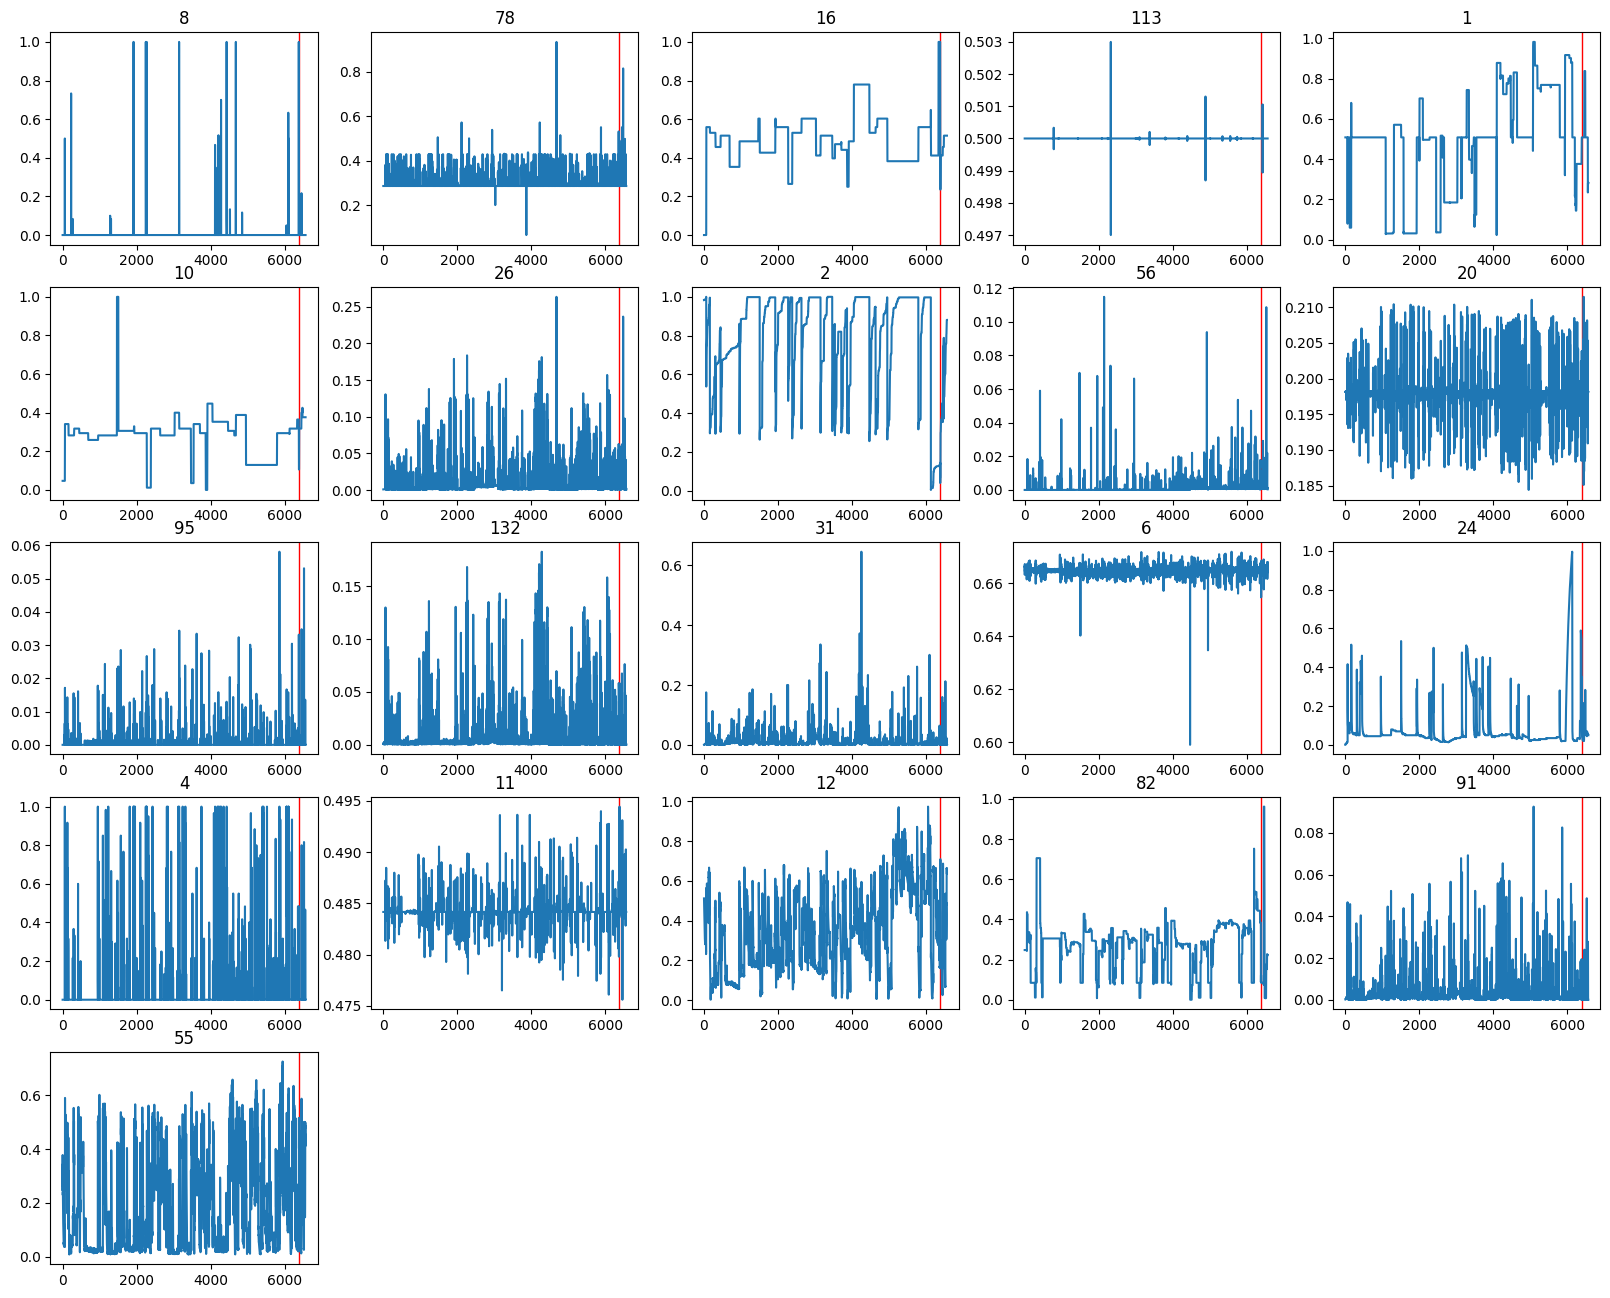

In [14]:
def plot_graph(data):

     fig = plt.figure(figsize=(20,16))

     # 데이터를 순회하면서 값이 1인 지점의 인덱스를 기록
     index_of_ones = [i for i, value in enumerate(select_dfs[0]) if abs(value-1) < 1e-5]

     idx = 0
     for i in range(21):
          fig.add_subplot(5, 5, idx+1)
          plt.plot(np.arange(0, len(data)), data[top_features.values[idx]])
          plt.title(top_features.values[idx])
          idx += 1
          # 값이 1인 인덱스에 세로 줄 그리기
          for j in index_of_ones:
               plt.axvspan(j, j, color='r', alpha=1)  # 세로 줄을 그림

     plt.show()

plot_graph(select_dfs)

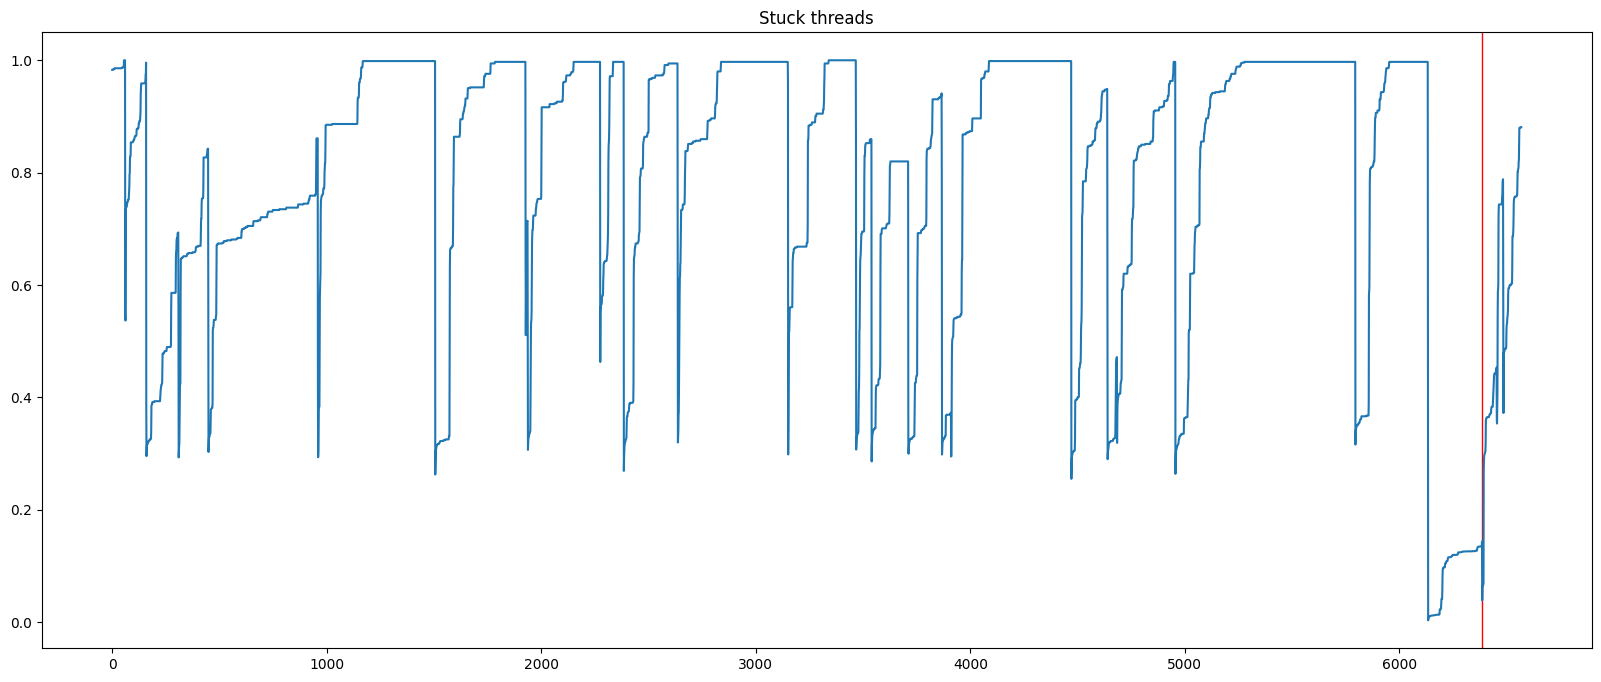

In [15]:
idx = 2
plt.figure(figsize=(20, 8))
plt.plot(np.arange(0, len(select_dfs[idx])), select_dfs[idx])
plt.title("Stuck threads")

index_of_ones = [i for i, value in enumerate(select_dfs[0]) if abs(value-1) < 1e-5]
for j in index_of_ones:
    plt.axvspan(j, j, color='r', alpha=1)  # 세로 줄을 그림

In [16]:
rolled_one_labels['lphost06_wls1'].value_counts()

0
0.0    6568
1.0       1
Name: count, dtype: int64

## 데이터셋 준비

In [17]:
signal = select_dfs.iloc[:, 1:]

In [38]:
chunk_size = 21 # 19분 단위로 capture
num_chunks = 100
length = len(signal)

chunk_dataset = []
timestamp = []
labels = []

def make_data(signal, chunk_dataset, timestamp, labels):

    while len(labels) < num_chunks//2: # 0~499
        idx = np.random.randint(0, length-chunk_size)
        chunk = np.array(signal.iloc[idx:idx+chunk_size].T)

        if rolled_one_labels['lphost06_wls1'][idx:idx+chunk_size].sum() > 0: # 이상 데이터가 포함되면
            chunk_dataset.append(chunk)
            timestamp.append(rolled_one_labels['lphost06_wls1'][idx:idx+chunk_size])
            labels.append([0, 1])                   # 이상

    while len(labels) < num_chunks: # 500 ~ 1000
        idx = np.random.randint(0, length-chunk_size)
        chunk = np.array(signal.iloc[idx:idx+chunk_size].T)
    
        if rolled_one_labels['lphost06_wls1'][idx:idx+chunk_size].sum() < 0.5: # 이상 데이터가 포함되면
            chunk_dataset.append(chunk)
            timestamp.append(rolled_one_labels['lphost06_wls1'][idx:idx+chunk_size])
            labels.append([1, 0])                   # 정상

    return chunk_dataset, timestamp, labels

chunk_dataset, timestamp, labels = make_data(signal, chunk_dataset, timestamp, labels)
chunk_dataset = torch.tensor(np.array(chunk_dataset), dtype=torch.float32)
timestamp = torch.tensor(np.array(timestamp))
labels = torch.tensor(np.array(labels), dtype=torch.float32)
print(chunk_dataset.shape)
print(labels.shape)
print(torch.sum(labels, axis=0))

torch.Size([100, 21, 21])
torch.Size([100, 2])
tensor([50., 50.])


In [39]:
timestamp

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [40]:
timestamp.sum()

tensor(50.0000, dtype=torch.float64)

In [41]:
labels[498:502, :]

tensor([], size=(0, 2))

In [42]:
sum(timestamp)

tensor([4.0000, 1.0000, 0.0000, 6.0000, 1.0000, 0.0000, 7.0000, 4.0000, 4.0000,
        3.0000, 2.0000, 0.0000, 1.0000, 0.0000, 3.0000, 4.0000, 4.0000, 2.0000,
        2.0000, 0.0000, 2.0000], dtype=torch.float64)

In [43]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, timestamp):
        self.data = data
        self.data = self.data.unsqueeze(1)
        self.labels = labels
        self.timestamp = timestamp

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        chunk = self.data[idx]
        label = self.labels[idx]
        time = self.timestamp[idx]

        return chunk, label, time

# CustomDataset 인스턴스 생성
dataset = CustomDataset(chunk_dataset, labels, timestamp)
dataloader = DataLoader(dataset,
                        batch_size=6,
                        shuffle=True)
# 데이터셋에서 첫 번째 샘플 가져오기 예시
feature, target, time = next(iter(dataloader))
print("첫 번째 샘플의 크기:", feature.size(), target.size(), time.size())
print(target)
print(time)

첫 번째 샘플의 크기: torch.Size([6, 1, 21, 21]) torch.Size([6, 2]) torch.Size([6, 21])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0

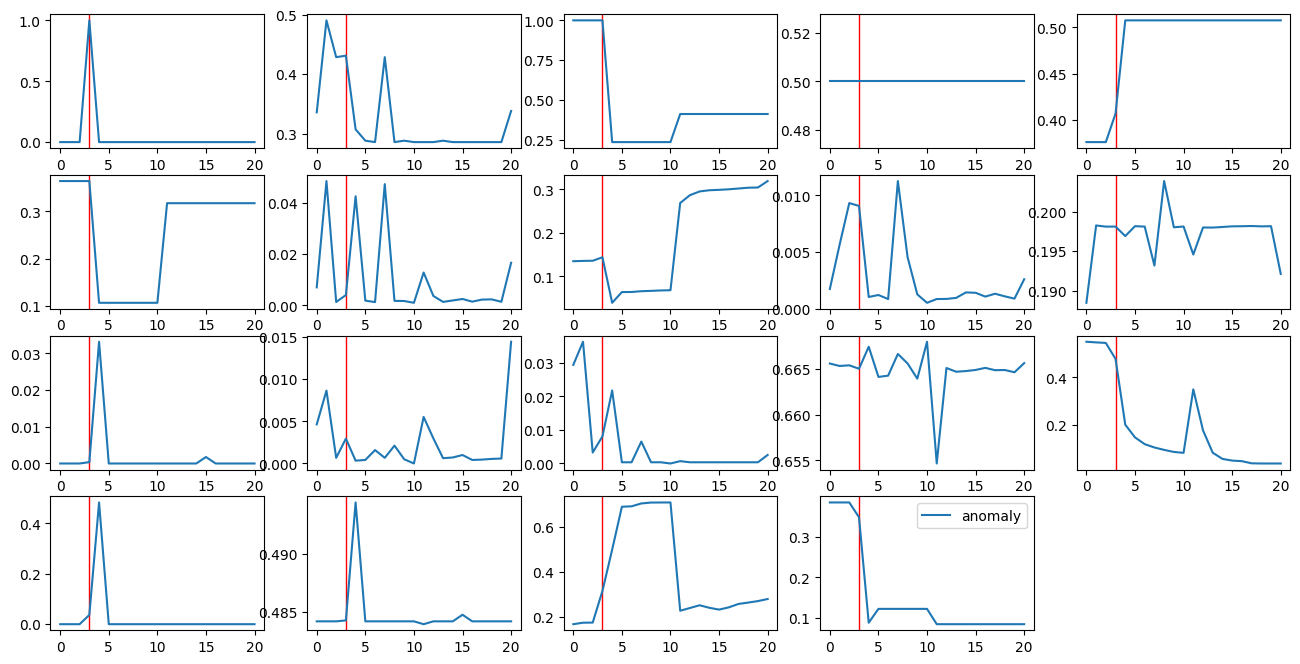

In [44]:
error_data_idx = torch.nonzero(torch.argmax(target, dim=1))[-1].item()

err_point = torch.nonzero(time[error_data_idx]).item()

fig = plt.figure(figsize=(16,8))

idx = 0
for i in range(19):
     fig.add_subplot(4, 5, idx+1)
     plt.plot(np.arange(0, chunk_size), feature[error_data_idx, 0, idx, :], label='anomaly')
     plt.axvspan(err_point, err_point, color='red', alpha=1)
     
     idx += 1

plt.legend()
plt.show()

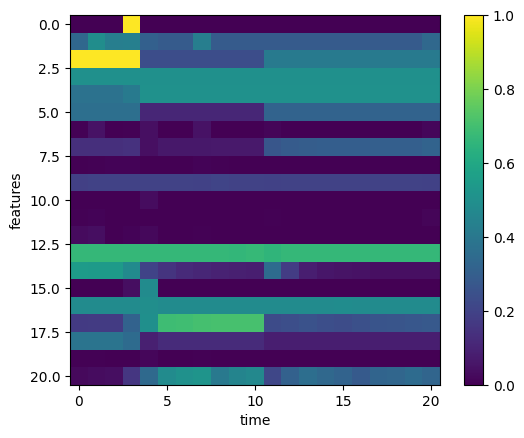

In [45]:
plt.imshow(feature[error_data_idx, 0, :, :])
plt.xlabel('time')
plt.ylabel('features')
plt.colorbar()

Train, Validation, Test 데이터 나누기 ( 6 : 2 : 2 )

In [46]:
batch_size = 128

data_size = len(dataset)
print(data_size)

train_size = int(data_size * 0.6)
val_size = int(data_size * 0.2)
test_size = data_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100
60
20
20


In [47]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

# GPU 사용 가능 -> 가장 빠른 번호 GPU, GPU 사용 불가 -> CPU 자동 지정 예시
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


## 모델 구축

In [48]:
# 간단한 컨볼루션 모델 정의
class GradCAM(nn.Module):
    def __init__(self, feature_size, chunk_size):
        super(GradCAM, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(64 * (feature_size-12) * (chunk_size-12), 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        self.gradients = None

    def forward(self, x):
        h1 = self.layer1(x)
        h1.register_hook(self.activations_hook)

        x = h1.view(h1.size(0), -1)
        x = self.classifier(x)
        return x

    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x, y, loss_gcam):

        pred_g = self.forward(x)
        loss_g = loss_gcam(pred_g, y)

        loss_g.backward()

        pooled_grad = torch.mean(self.gradients, dim=[0, 2, 3]) # (1, 64, 7, 7) -> (64)     # (neuron importance weight, a)

        activations = self.layer1(x)
        for i in range(self.gradients.size(1)): # 각 feature 마다 weight와 곱하기
            activations[:, i, :, :] *= pooled_grad[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
    
        return heatmap
    

In [49]:
from torchsummary import summary
gradcam = GradCAM(21, chunk_size).to(device)
summary(gradcam, (1, 21, chunk_size), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 17, 17]             416
              ReLU-2           [-1, 16, 17, 17]               0
            Conv2d-3           [-1, 32, 13, 13]          12,832
              ReLU-4           [-1, 32, 13, 13]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
              ReLU-6             [-1, 64, 9, 9]               0
            Linear-7                  [-1, 100]         518,500
              ReLU-8                  [-1, 100]               0
            Linear-9                    [-1, 2]             202
Total params: 583,214
Trainable params: 583,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.22
Estimated Total Size (MB): 2.46
-------------------------------------------

## 학습 파라미터 설정

In [50]:
# 손실 함수, 최적화 기법 정의

lr = 1e-4
epochs = 1000

loss_gcam = nn.CrossEntropyLoss()

optimizer_gcam = optim.Adam(gradcam.parameters(), lr=lr)

In [51]:
train_hist_loss = []
val_hist_loss = []
train_hist_acc = []
val_hist_acc = []

# 모델 학습
for epoch in range(epochs+1):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0

    for tr_x, tr_y, _ in train_loader:
        tr_x = tr_x.to(device)
        tr_y = tr_y.to(device)
                
        pred = gradcam(tr_x)
        
        loss = loss_gcam(pred, tr_y)

        optimizer_gcam.zero_grad()
        loss.backward()
        optimizer_gcam.step()

        train_loss += loss.item()

        tr_pred = torch.argmax(pred, axis=1)
        tr_label = torch.argmax(tr_y, axis=1)

        tr_pred = tr_pred.detach().cpu().numpy()
        tr_label = tr_label.detach().cpu().numpy()
        correct = sum(tr_pred == tr_label)

        train_acc += correct

    for val_x, val_y, _ in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        outputs = gradcam(val_x)
        
        loss = loss_gcam(outputs, val_y)
        val_loss += loss.item()

        val_pred = torch.argmax(outputs, axis=1)
        val_label = torch.argmax(val_y, axis=1)

        val_pred = val_pred.detach().cpu().numpy()
        val_label = val_label.detach().cpu().numpy()
        correct = sum(val_pred == val_label)

        val_acc += correct

    train_avg_loss = train_loss/train_size
    train_hist_loss.append(train_avg_loss)

    val_avg_loss = val_loss/val_size
    val_hist_loss.append(val_avg_loss)

    train_avg_acc = train_acc/train_size
    val_avg_acc = val_acc/val_size

    train_hist_acc.append(train_avg_acc)
    val_hist_acc.append(val_avg_acc)


    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch}], Train Loss: {train_avg_loss:.5f}, \t\t Val Loss: {val_avg_loss:.5f}, \n\t \
               Train Accuracy : {train_avg_acc*100:.2f}%, \t Val Accuracy : {val_avg_acc*100:.2f}%')
        
    if val_avg_acc*100 >= 98 and epoch > 100:
        print(f'Epoch [{epoch}], Train Loss: {train_avg_loss:.5f}, \t\t Val Loss: {val_avg_loss:.5f}, \n\t \
               Train Accuracy : {train_avg_acc*100:.2f}%, \t Val Accuracy : {val_avg_acc*100:.2f}%')
        break

Epoch [0], Train Loss: 0.01161, 		 Val Loss: 0.03389, 
	                Train Accuracy : 43.33%, 	 Val Accuracy : 65.00%
Epoch [100], Train Loss: 0.00123, 		 Val Loss: 0.00348, 
	                Train Accuracy : 98.33%, 	 Val Accuracy : 95.00%
Epoch [147], Train Loss: 0.00097, 		 Val Loss: 0.00250, 
	                Train Accuracy : 98.33%, 	 Val Accuracy : 100.00%


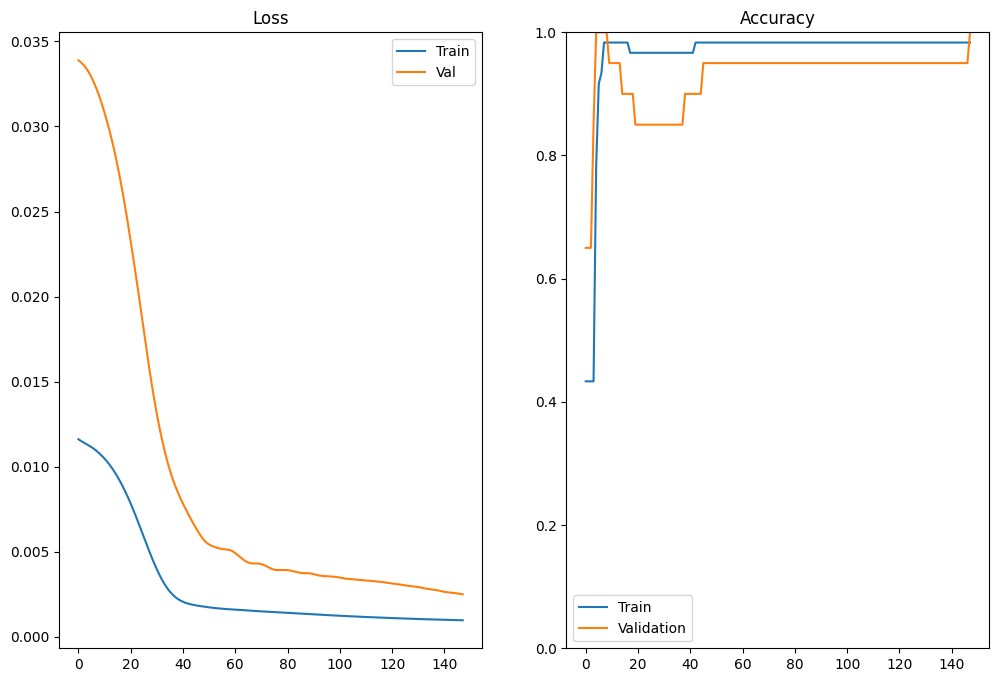

In [52]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 2, 1)
plt.plot(train_hist_loss, label='Train')
plt.plot(val_hist_loss, label='Val')
plt.legend()
plt.title('Loss')

fig.add_subplot(1, 2, 2)
plt.plot(train_hist_acc, label='Train')
plt.plot(val_hist_acc, label='Validation')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 1)
plt.show()

In [53]:
test_acc = 0
for i, (data_, labels_, _) in enumerate(test_loader):

    data_ = data_.to(device)
    labels_ = labels_.to(device)

    target_ = gradcam(data_)
 
    pred_ = torch.argmax(target_, axis=1)
    labels_ = torch.argmax(labels_, axis=1)

    pred_ = pred_.detach().cpu().numpy()
    labels_ = labels_.detach().cpu().numpy()
    correct = sum(labels_ == pred_)

    test_acc += correct

print(f'Test Accuracy : {((test_acc / test_size) * 100):.3f}%')

Test Accuracy : 100.000%


In [54]:
gradcam.get_activations_gradient().shape

torch.Size([60, 64, 9, 9])

In [55]:
x = chunk_dataset[0].unsqueeze(0).unsqueeze(1).to(device)
y = labels[0].unsqueeze(0).to(device)

activations = gradcam.get_activations(x, y, loss_gcam)
activations.shape

/home/oem/anaconda3/envs/gradcam_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


torch.Size([9, 9])

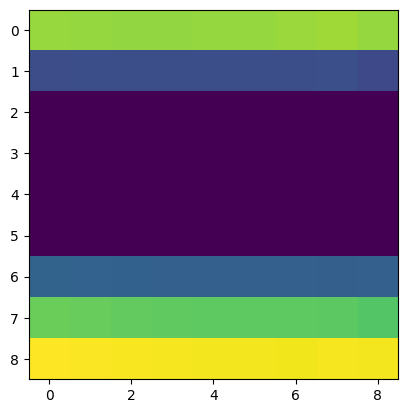

In [56]:
plt.imshow(activations.detach().cpu().numpy())

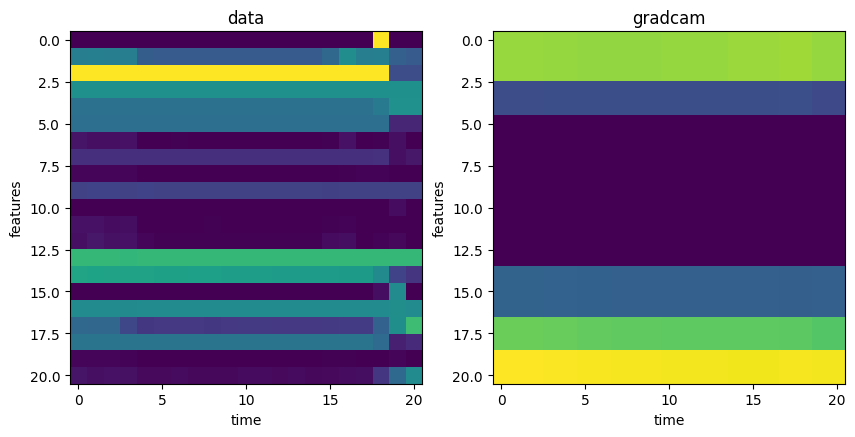

In [57]:
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(1, 2, 1)
plt.imshow(x.squeeze().squeeze().detach().cpu().numpy())
plt.title('data')
plt.xlabel('time')
plt.ylabel('features')

fig.add_subplot(1, 2, 2)
gc = F.interpolate(activations.unsqueeze(0).unsqueeze(1), size=(chunk_size, chunk_size))
plt.imshow(gc[0, 0].detach().cpu().numpy())
plt.title('gradcam')
plt.xlabel('time')
plt.ylabel('features')

plt.show()

In [58]:
# Featured CNN 모델 정의
class Featred_GradCAM(nn.Module):
    def __init__(self, feature_size, chunk_size):
        super(Featred_GradCAM, self).__init__()
        
        self.feature_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5,1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(5,1)),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(5,1)),
            nn.ReLU(),
        )

        self.time_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,5)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1,5)),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1,5)),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * (chunk_size-12) * feature_size, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        self.gradients1 = None
        self.gradients2 = None


    def forward(self, x):
        x1 = self.feature_layer1(x)
        
        x2 = self.time_layer1(x)

        h1 = x1.register_hook(self.activations_hook1)
        h2 = x2.register_hook(self.activations_hook2)

        x2 = x2.permute(0,1,3,2)
        x = torch.concat((x1,x2), dim=1)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def activations_hook1(self,grad):
        self.gradients1 = grad

    def activations_hook2(self,grad):
        self.gradients2 = grad

    def get_activations_gradient1(self):
        return self.gradients1

    def get_activations_gradient2(self):
        return self.gradients2

    def get_activations1(self,x):
        x = self.time_layer1(x)
        return x

    def get_activations2(self,x):
        x = self.feature_layer1(x)
        return x

In [59]:
from torchsummary import summary
f_gradcam = Featred_GradCAM(21, chunk_size).to(device)
summary(f_gradcam, (1, 21, chunk_size), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 17, 21]              96
              ReLU-2           [-1, 16, 17, 21]               0
            Conv2d-3           [-1, 32, 13, 21]           2,592
              ReLU-4           [-1, 32, 13, 21]               0
            Conv2d-5            [-1, 32, 9, 21]           5,152
              ReLU-6            [-1, 32, 9, 21]               0
            Conv2d-7           [-1, 16, 21, 17]              96
              ReLU-8           [-1, 16, 21, 17]               0
            Conv2d-9           [-1, 32, 21, 13]           2,592
             ReLU-10           [-1, 32, 21, 13]               0
           Conv2d-11            [-1, 32, 21, 9]           5,152
             ReLU-12            [-1, 32, 21, 9]               0
           Linear-13                  [-1, 100]       1,209,700
             ReLU-14                  [

/home/oem/anaconda3/envs/gradcam_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [60]:
loss_gcam_plus = nn.CrossEntropyLoss()
optimizer_gcam_plus = optim.Adam(f_gradcam.parameters(), lr=lr)

In [61]:
train_hist_loss2 = []
val_hist_loss2 = []
train_hist_acc2 = []
val_hist_acc2 = []

# 모델 학습
for epoch in range(epochs+1):
    train_loss2 = 0
    val_loss2 = 0
    train_acc2 = 0
    val_acc2 = 0

    for (data, target, _) in train_loader:
        data = data.to(device)
        target = target.to(device)

        outputs = f_gradcam(data)
        
        loss2 = loss_gcam_plus(outputs, target)

        optimizer_gcam_plus.zero_grad()
        loss2.backward()
        optimizer_gcam_plus.step()

        train_loss2 += loss2.item()

        tr_pred = torch.argmax(outputs, axis=1)
        tr_label = torch.argmax(target, axis=1)

        tr_pred = tr_pred.detach().cpu().numpy()
        tr_label = tr_label.detach().cpu().numpy()
        correct2 = sum(tr_pred == tr_label)

        train_acc2 += correct2
        
    for (data, target, _) in val_loader:
        data = data.to(device)
        target = target.to(device)

        outputs = f_gradcam(data)
        
        loss2 = loss_gcam_plus(outputs, target)
        val_loss2 += loss2.item()

        val_pred = torch.argmax(outputs, axis=1)
        val_label = torch.argmax(target, axis=1)

        val_pred = val_pred.detach().cpu().numpy()
        val_label = val_label.detach().cpu().numpy()
        correct2 = sum(val_pred == val_label)

        val_acc2 += correct2

    train_avg_loss2 = train_loss2/train_size
    train_hist_loss2.append(train_avg_loss2)

    val_avg_loss2 = val_loss2/val_size
    val_hist_loss2.append(val_avg_loss2)

    train_avg_acc2 = train_acc2/train_size
    val_avg_acc2 = val_acc2/val_size

    train_hist_acc2.append(train_avg_acc2)
    val_hist_acc2.append(val_avg_acc2)


    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch}], Train Loss: {train_avg_loss2:.5f}, \t\t Val Loss: {val_avg_loss2:.5f}, \n \
               Train Accuracy : {train_avg_acc2*100:.2f}%, \t Val Accuracy : {val_avg_acc2*100:.2f}%')
        
    if val_avg_acc2*100 >= 98 and epoch > 100:
        print(f'Epoch [{epoch}], Train Loss: {train_avg_loss2:.5f}, \t\t Val Loss: {val_avg_loss2:.5f}, \n \
               Train Accuracy : {train_avg_acc2*100:.2f}%, \t Val Accuracy : {val_avg_acc2*100:.2f}%')
        break

Epoch [0], Train Loss: 0.01142, 		 Val Loss: 0.03678, 
                Train Accuracy : 56.67%, 	 Val Accuracy : 35.00%
Epoch [100], Train Loss: 0.00140, 		 Val Loss: 0.00322, 
                Train Accuracy : 98.33%, 	 Val Accuracy : 100.00%
Epoch [101], Train Loss: 0.00138, 		 Val Loss: 0.00314, 
                Train Accuracy : 98.33%, 	 Val Accuracy : 100.00%


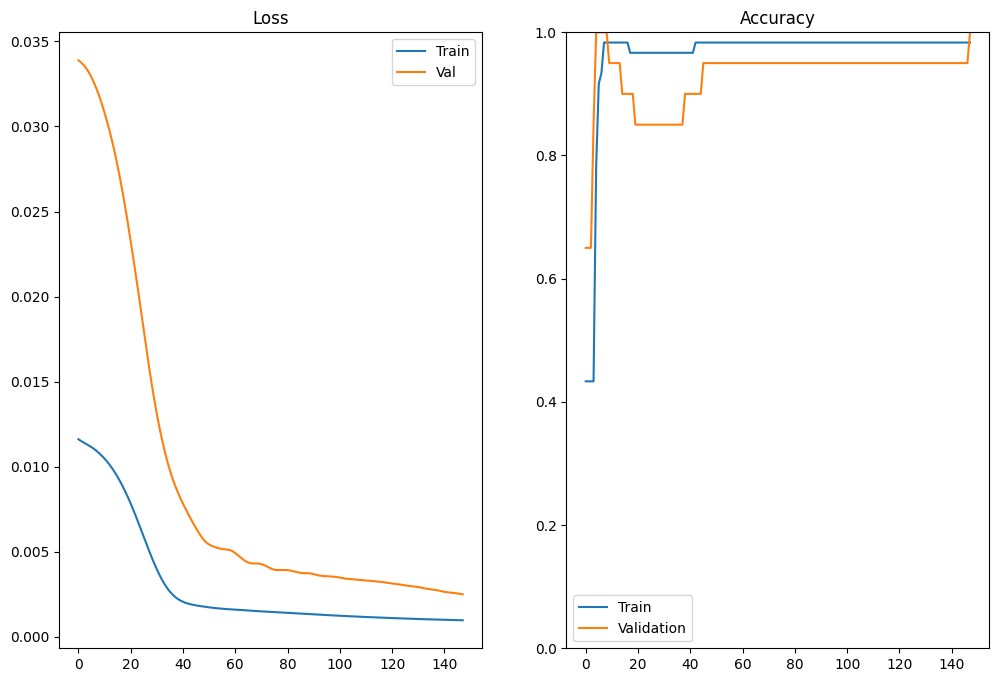

In [62]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 2, 1)
plt.plot(train_hist_loss, label='Train')
plt.plot(val_hist_loss, label='Val')
plt.legend()
plt.title('Loss')

fig.add_subplot(1, 2, 2)
plt.plot(train_hist_acc, label='Train')
plt.plot(val_hist_acc, label='Validation')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 1)
plt.show()

In [63]:
test_acc = 0
for i, (data_, labels_, _) in enumerate(test_loader):

    data_ = data_.to(device)
    labels_ = labels_.to(device)

    target_ = f_gradcam(data_)
 
    pred_ = torch.argmax(target_, axis=1)
    labels_ = torch.argmax(labels_, axis=1)

    pred_ = pred_.detach().cpu().numpy()
    labels_ = labels_.detach().cpu().numpy()
    correct = sum(labels_ == pred_)

    test_acc += correct

print(f'Test Accuracy : {((test_acc / test_size) * 100):.3f}%')

Test Accuracy : 100.000%


In [64]:
activations1 = f_gradcam.get_activations1(chunk_dataset[0].unsqueeze(0).unsqueeze(1).to(device)).detach()
activations2 = f_gradcam.get_activations2(chunk_dataset[0].unsqueeze(0).unsqueeze(1).to(device)).detach()
activations1.shape

torch.Size([1, 32, 21, 9])

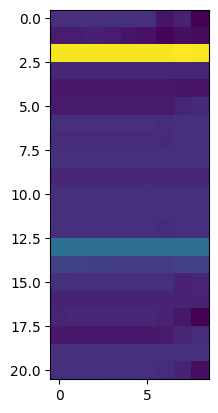

In [65]:
time_gc = torch.mean(activations1[0], dim=0).detach().cpu().numpy()
plt.imshow(time_gc)
plt.show()

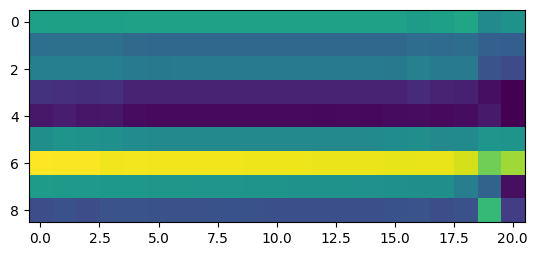

In [66]:
feature_gc = torch.mean(activations2[0],dim =0).detach().cpu().numpy()
plt.imshow(feature_gc)
plt.show()

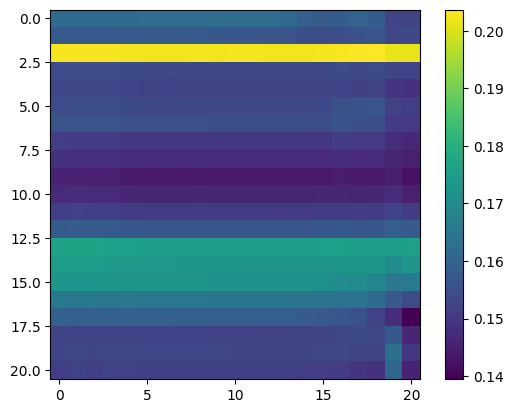

In [67]:
from PIL import Image

time_gc = Image.fromarray(time_gc)
feature_gc = Image.fromarray(feature_gc)

time_gc = time_gc.resize((chunk_size, chunk_size))
feature_gc = feature_gc.resize((chunk_size, chunk_size))

time_gc = np.asarray(time_gc)
feature_gc = np.asarray(feature_gc)
gc = time_gc+feature_gc

plt.imshow(gc)
plt.colorbar()